	•	Season: 2025-2026 (neueste in deiner Datei)
	•	Ligen: Big-5 (PL, La Liga, Serie A, Bundesliga, Ligue 1)
	•	Sample size: 90s >= 8 (≈ 720+ Minuten)
	•	Optional: Age <= 28 (mehr „scouting vibe“)

In [47]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent   # ← EIN Level hoch

players = pd.read_csv(
    PROJECT_ROOT / "data" / "processed" / "player_scores_all_seasons_long.csv"
)

squads = pd.read_csv(
    PROJECT_ROOT / "data" / "processed" / "squad_scores_all_seasons.csv"
)

In [48]:
players.columns.tolist()

['Player',
 'Squad',
 'Comp',
 'Pos',
 'Age',
 'Min',
 '90s',
 'OffScore_abs',
 'OffBand',
 'MidScore_abs',
 'MidBand',
 'DefScore_abs',
 'DefBand',
 'Season']

In [49]:
import numpy as np

def pick_primary_score(row):
    pos = str(row["Pos"])
    if pos.startswith("Off") or pos == "FW":
        return float(row["OffScore_abs"])
    if pos.startswith("Mid") or pos == "MF":
        return float(row["MidScore_abs"])
    if pos.startswith("Def") or pos == "DF":
        return float(row["DefScore_abs"])
    # Fallback: nimm den besten der drei
    return float(max(row["OffScore_abs"], row["MidScore_abs"], row["DefScore_abs"]))

players["PrimaryScore"] = players.apply(pick_primary_score, axis=1)

In [50]:
squads.columns.tolist()

['Season',
 'Squad',
 'Min_squad',
 '90s_squad',
 'Age_squad_mean',
 'NumPlayers_squad',
 'OffScore_squad',
 'MidScore_squad',
 'DefScore_squad',
 'OverallScore_squad']

In [51]:
# Kandidaten-Namen, die oft vorkommen
candidates = [
    "OverallScore_squad", "OverallScore", "SquadScore", "Score",
    "TeamScore", "Overall", "Rating"
]

overall_col = next((c for c in candidates if c in squads.columns), None)

if overall_col is None:
    # fallback: nimm die erste Spalte, die "overall" oder "score" enthält
    score_like = [c for c in squads.columns if ("overall" in c.lower()) or ("score" in c.lower())]
    if not score_like:
        raise ValueError(f"Keine passende Overall/Score-Spalte in squads gefunden. Spalten: {squads.columns.tolist()}")
    overall_col = score_like[0]

print("Using squad overall column:", overall_col)

df = players.merge(
    squads[["Season","Squad", overall_col]],
    on=["Season","Squad"],
    how="left"
).rename(columns={overall_col: "SquadOverall"})

Using squad overall column: OverallScore_squad


In [52]:
def zscore(s):
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return s*0
    return (s - mu) / sd

df["PlayerZ"] = df.groupby(["Season","Comp","Pos"])["PrimaryScore"].transform(zscore)
df["SquadZ"]  = df.groupby(["Season","Comp"])["SquadOverall"].transform(zscore)

df["Underrated"] = df["PlayerZ"] - df["SquadZ"]

In [71]:
big5 = {
    "eng Premier League", "es La Liga", "it Serie A", "de Bundesliga", "fr Ligue 1"
}

latest = df["Season"].dropna().astype(str).sort_values().iloc[-1]  # nimmt die neueste Season aus der Datei
print("Latest season detected:", latest)

view = df[
    (df["Season"].astype(str) == str(latest)) &
    (df["Comp"].isin(big5)) &
    (df["90s"] >= 8)
].copy()

big5 = {
    "eng Premier League", "es La Liga", "it Serie A", "de Bundesliga", "fr Ligue 1"
}

latest = df["Season"].dropna().astype(str).sort_values().iloc[-1]  # nimmt die neueste Season aus der Datei
print("Latest season detected:", latest)

view = df[
    (df["Season"].astype(str) == str(latest)) &
    (df["Comp"].isin(big5)) &
    (df["90s"] >= 8) &
    (df["Age"] <= 23)
].copy()

top10 = view.sort_values("Underrated", ascending=False).head(10)

top10_out = top10[["Player","Squad","Comp","Pos","Age","90s","PrimaryScore","SquadOverall","Underrated"]]
top10_out

top10_out = view[view["Pos"].isin(["FW","MF"])].sort_values("Underrated", ascending=False).head(10)
top10_out[["Player","Squad","Comp","Pos","Age","90s","PrimaryScore","SquadOverall","Underrated"]]

Latest season detected: 2025-2026
Latest season detected: 2025-2026


,Player,Squad,Comp,Pos,Age,90s,PrimaryScore,SquadOverall,Underrated
21139,Medon Berisha,Lecce,it Serie A,MF,22.0,9.7,739.381443,291.668253,3.554543
22155,Johan Manzambi,Freiburg,de Bundesliga,MF,20.0,9.3,490.681004,316.956065,1.894821
21397,Kévin Danois,Auxerre,fr Ligue 1,MF,21.0,12.8,456.875000,305.703442,1.778967
21934,Yassine Kechta,Le Havre,fr Ligue 1,MF,23.0,9.5,382.877193,289.943363,1.611653
20961,Ebenezer Akinsanmiro,Pisa,it Serie A,MF,21.0,9.5,419.859649,292.327801,1.551312
23010,Nico Williams,Athletic Club,es La Liga,FW,23.0,9.3,445.120632,316.732976,1.530097
21614,Joel Fujita,St. Pauli,de Bundesliga,MF,23.0,12.8,434.010417,319.530649,1.498479
22051,Johann Lepenant,Nantes,fr Ligue 1,MF,23.0,9.1,366.608059,291.294101,1.491766
21080,Valentín Barco,Strasbourg,fr Ligue 1,MF,21.0,11.8,697.627119,415.860759,1.307243
20918,Matthis Abline,Nantes,fr Ligue 1,FW,22.0,13.9,281.878503,291.294101,1.219843


In [69]:
def format_player_list(df10):
    lines = []
    for i, r in enumerate(df10.itertuples(index=False), 1):
        lines.append(f"{i}) {r.Player} ({r.Squad})")
    return "\n".join(lines)

player_lines = format_player_list(top10_mffw)

post = f"""I pulled the most underrated players from my PlayerScore dataset (Big-5 leagues, {latest}, min. 8 full 90s).

How I define “underrated” (data-only):
Hidden Gem Index = (position-specific PlayerScore z-score) − (team strength z-score)
→ players who rate highly for their role while playing in weaker squads.

Top 10 hidden gems:
{player_lines}

🔗 App demo: https://player-score.streamlit.app
If you work in scouting/recruitment: who should I sanity-check next?

#FootballAnalytics #DataEngineering #Scouting #SoccerAnalytics #Python #Streamlit
"""

print(post)

I pulled the most underrated players from my PlayerScore dataset (Big-5 leagues, 2025-2026, min. 8 full 90s).

How I define “underrated” (data-only):
Hidden Gem Index = (position-specific PlayerScore z-score) − (team strength z-score)
→ players who rate highly for their role while playing in weaker squads.

Top 10 hidden gems:
1) Medon Berisha (Lecce)
2) Luis Milla (Getafe)
3) Gauthier Hein (Metz)
4) Haris Tabakovic (Gladbach)
5) Maxime Lopez (Paris FC)
6) Romain Del Castillo (Brest)
7) Ruslan Malinovskyi (Genoa)
8) Jari Vandeputte (Cremonese)
9) Vincenzo Grifo (Freiburg)
10) Johan Manzambi (Freiburg)

🔗 App demo: https://player-score.streamlit.app
If you work in scouting/recruitment: who should I sanity-check next?

#FootballAnalytics #DataEngineering #Scouting #SoccerAnalytics #Python #Streamlit



In [72]:
import matplotlib.pyplot as plt
import textwrap

# Für saubere Labels
df10 = top10_out.copy()

df10["label"] = df10.apply(
    lambda r: f"{r['Player']} ({r['Squad']})",
    axis=1
)

# Sortierung für Plots
df10 = df10.sort_values("Underrated", ascending=True)  # für horizontale Bars: klein oben, groß unten

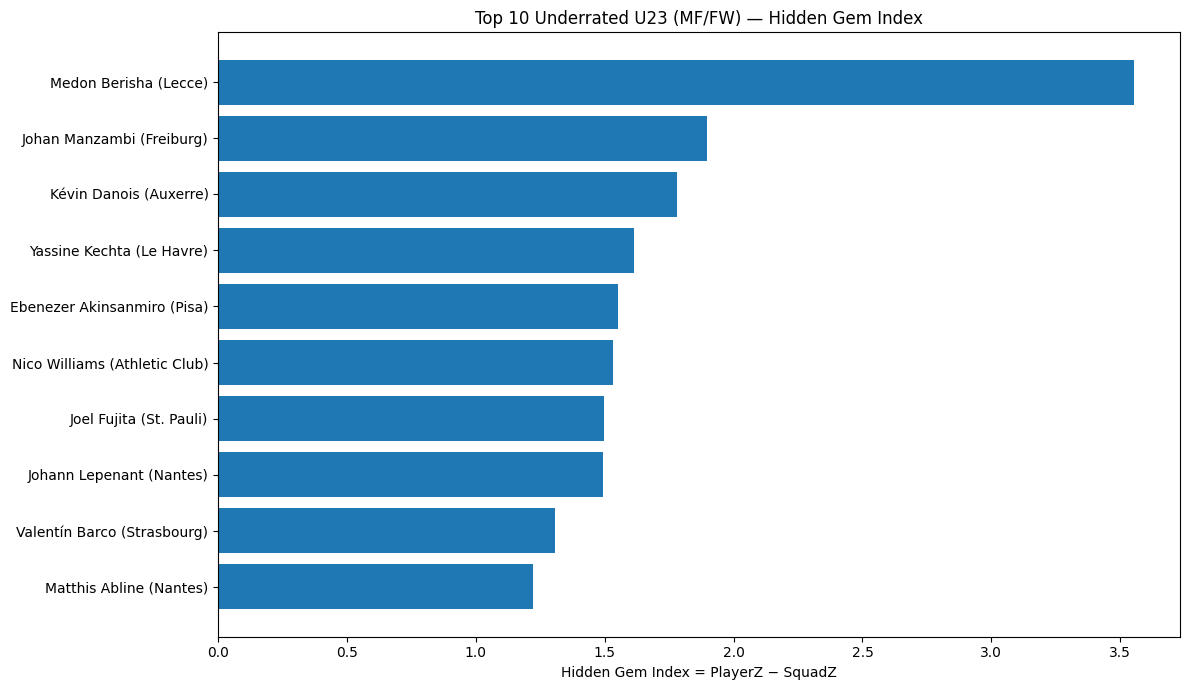

In [73]:
plt.figure(figsize=(12, 7))
plt.barh(df10["label"], df10["Underrated"])
plt.title("Top 10 Underrated U23 (MF/FW) — Hidden Gem Index")
plt.xlabel("Hidden Gem Index = PlayerZ − SquadZ")
plt.ylabel("")

plt.tight_layout()
plt.savefig("underrated_top10_bar.png", dpi=200, bbox_inches="tight")
plt.show()

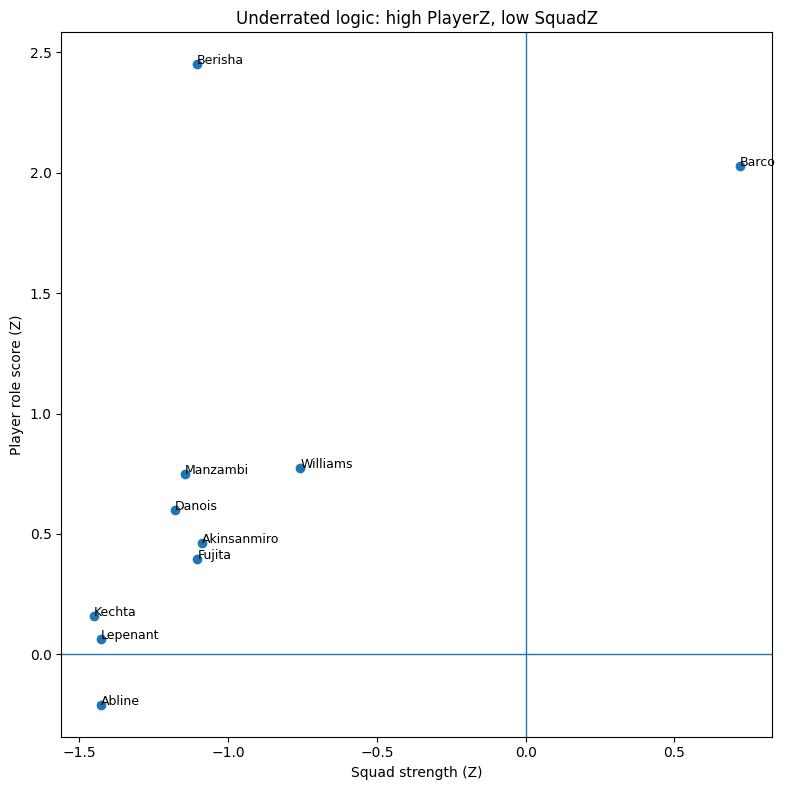

In [74]:
plt.figure(figsize=(8, 8))
plt.scatter(df10["SquadZ"], df10["PlayerZ"])

for _, r in df10.iterrows():
    plt.text(r["SquadZ"], r["PlayerZ"], r["Player"].split()[-1], fontsize=9)

plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

plt.title("Underrated logic: high PlayerZ, low SquadZ")
plt.xlabel("Squad strength (Z)")
plt.ylabel("Player role score (Z)")

plt.tight_layout()
plt.savefig("underrated_scatter_logic.png", dpi=200, bbox_inches="tight")
plt.show()

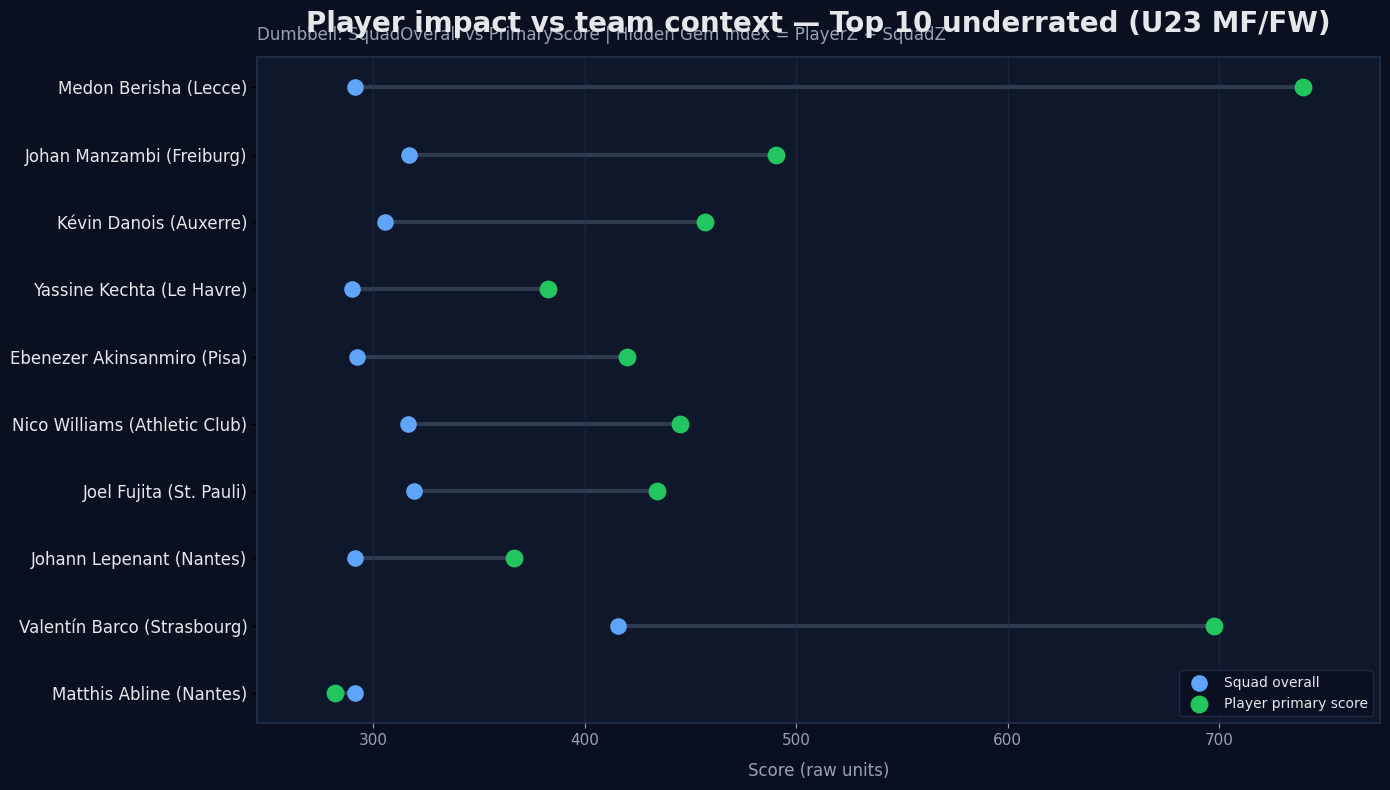

Saved: underrated_dumbbell_branding.png


In [77]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Input ----
dfd = top10_out.copy()
dfd["label"] = dfd.apply(lambda r: f"{r['Player']} ({r['Squad']})", axis=1)
dfd = dfd.sort_values("Underrated", ascending=True).reset_index(drop=True)

# ---- Branding Farben (wie Tabelle) ----
BG = "#0b1020"
PANEL = "#0f172a"
GRID = "#22304a"
TEXT = "#e5e7eb"
SUB = "#94a3b8"
SQUAD = "#60a5fa"   # team point
PLAYER = "#22c55e"  # player point (accent)
LINE = "#334155"

title = "Player impact vs team context — Top 10 underrated (U23 MF/FW)"
subtitle = "Dumbbell: SquadOverall vs PrimaryScore | Hidden Gem Index = PlayerZ − SquadZ"

# ---- Figure ----
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor(BG)
ax.set_facecolor(PANEL)

y = np.arange(len(dfd))

# ---- Dumbbell lines ----
ax.hlines(y, dfd["SquadOverall"], dfd["PrimaryScore"], color=LINE, linewidth=3, alpha=0.9, zorder=1)

# ---- Points ----
ax.scatter(dfd["SquadOverall"], y, s=120, color=SQUAD, label="Squad overall", zorder=3)
ax.scatter(dfd["PrimaryScore"], y, s=140, color=PLAYER, label="Player primary score", zorder=4)

# ---- Labels on points (optional, small) ----
# Uncomment if you want values printed next to dots:
# for i, r in dfd.iterrows():
#     ax.text(r["SquadOverall"], i, f" {r['SquadOverall']:.0f}", va="center", ha="left", fontsize=10, color=SUB)
#     ax.text(r["PrimaryScore"], i, f" {r['PrimaryScore']:.0f}", va="center", ha="left", fontsize=10, color=TEXT)

# ---- Y labels ----
ax.set_yticks(y)
ax.set_yticklabels(dfd["label"], fontsize=12, color=TEXT)

# ---- X axis + grid styling ----
ax.tick_params(axis="x", colors=SUB, labelsize=11)
ax.grid(axis="x", color=GRID, linewidth=1, alpha=0.6)
ax.grid(axis="y", visible=False)

# ---- Spines ----
for spine in ax.spines.values():
    spine.set_color(GRID)
    spine.set_linewidth(1.2)

# ---- Titles ----
ax.set_title(title, fontsize=20, fontweight="bold", color=TEXT, pad=18)
ax.text(0.0, 1.02, subtitle, transform=ax.transAxes, fontsize=12, color=SUB, va="bottom")

ax.set_xlabel("Score (raw units)", fontsize=12, color=SUB, labelpad=10)

# ---- Legend (styled) ----
leg = ax.legend(frameon=True, loc="lower right")
leg.get_frame().set_facecolor(BG)
leg.get_frame().set_edgecolor(GRID)
for t in leg.get_texts():
    t.set_color(TEXT)

# ---- Nice x-limits (padding) ----
xmin = min(dfd["SquadOverall"].min(), dfd["PrimaryScore"].min())
xmax = max(dfd["SquadOverall"].max(), dfd["PrimaryScore"].max())
pad = (xmax - xmin) * 0.08 if xmax > xmin else 50
ax.set_xlim(xmin - pad, xmax + pad)

plt.tight_layout()

out_path = "underrated_dumbbell_branding.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

print("Saved:", out_path)

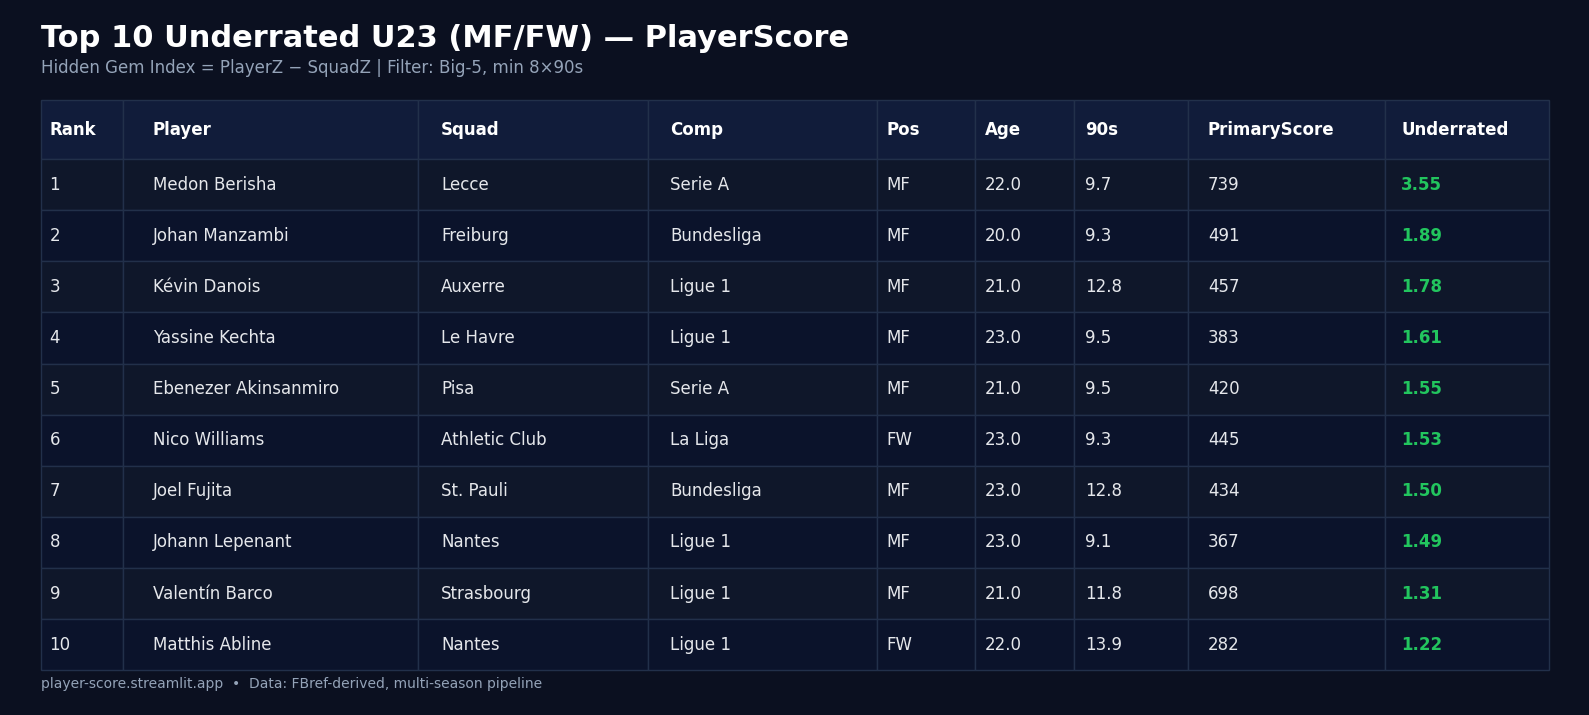

Saved: underrated_top10_table_branding.png


In [76]:
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import fill

# ---- Input ----
df = top10_out.copy()

# Optional: schöneres Sorting (Top oben)
df = df.sort_values("Underrated", ascending=False).head(10).reset_index(drop=True)
df.insert(0, "Rank", df.index + 1)

# ---- Format für Anzeige ----
show_cols = ["Rank", "Player", "Squad", "Comp", "Pos", "Age", "90s", "PrimaryScore", "Underrated"]
df = df[show_cols].copy()

df["90s"] = df["90s"].map(lambda x: f"{x:.1f}")
df["PrimaryScore"] = df["PrimaryScore"].map(lambda x: f"{x:.0f}")
df["Underrated"] = df["Underrated"].map(lambda x: f"{x:.2f}")

# Optional: lange Team-/League-Namen kürzen (LinkedIn-friendly)
df["Comp"] = df["Comp"].replace({
    "eng Premier League": "Premier League",
    "es La Liga": "La Liga",
    "it Serie A": "Serie A",
    "de Bundesliga": "Bundesliga",
    "fr Ligue 1": "Ligue 1",
})

# ---- Branding Farben (dark theme) ----
BG = "#0b1020"
PANEL = "#0f172a"
HEADER_BG = "#111c3a"
ROW_A = "#0f172a"
ROW_B = "#0b132b"
GRID = "#22304a"
TEXT = "#e5e7eb"
MUTED = "#cbd5e1"
ACCENT = "#22c55e"  # Underrated highlight
TITLE = "#ffffff"
SUB = "#94a3b8"

title = "Top 10 Underrated U23 (MF/FW) — PlayerScore"
subtitle = "Hidden Gem Index = PlayerZ − SquadZ | Filter: Big-5, min 8×90s"

# ---- Figure Setup ----
nrows, ncols = df.shape
fig_w = 16
fig_h = 1.2 + 0.55 * (nrows + 1)  # dynamisch nach Zeilen
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
fig.patch.set_facecolor(BG)
ax.set_facecolor(BG)
ax.axis("off")

# ---- Title Block ----
ax.text(
    0.02, 0.98, title,
    transform=ax.transAxes, ha="left", va="top",
    fontsize=22, fontweight="bold", color=TITLE
)
ax.text(
    0.02, 0.93, subtitle,
    transform=ax.transAxes, ha="left", va="top",
    fontsize=12, color=SUB
)

# ---- Table ----
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="left",
    colLoc="left",
    bbox=[0.02, 0.05, 0.96, 0.82],  # [left,bottom,width,height]
)

table.auto_set_font_size(False)
table.set_fontsize(12)

# Spaltenbreiten (tweakbar)
col_widths = {
    "Rank": 0.05,
    "Player": 0.18,
    "Squad": 0.14,
    "Comp": 0.14,
    "Pos": 0.06,
    "Age": 0.06,
    "90s": 0.07,
    "PrimaryScore": 0.12,
    "Underrated": 0.10,
}

# Apply styling
underrated_col_idx = list(df.columns).index("Underrated")

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor(GRID)
    cell.set_linewidth(1.0)

    if row == 0:  # header
        cell.set_facecolor(HEADER_BG)
        cell.get_text().set_color(TITLE)
        cell.get_text().set_fontweight("bold")
        cell.set_height(cell.get_height() * 1.15)
    else:
        cell.set_facecolor(ROW_A if row % 2 == 1 else ROW_B)
        cell.get_text().set_color(TEXT)

        # Highlight Underrated column
        if col == underrated_col_idx:
            cell.get_text().set_color(ACCENT)
            cell.get_text().set_fontweight("bold")

    # Set column widths
    col_name = df.columns[col]
    if col_name in col_widths:
        cell.set_width(col_widths[col_name])

# Footer / watermark-style note
ax.text(
    0.02, 0.02, "player-score.streamlit.app  •  Data: FBref-derived, multi-season pipeline",
    transform=ax.transAxes, ha="left", va="bottom",
    fontsize=10, color=SUB
)

plt.tight_layout()
out_path = "underrated_top10_table_branding.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

print("Saved:", out_path)

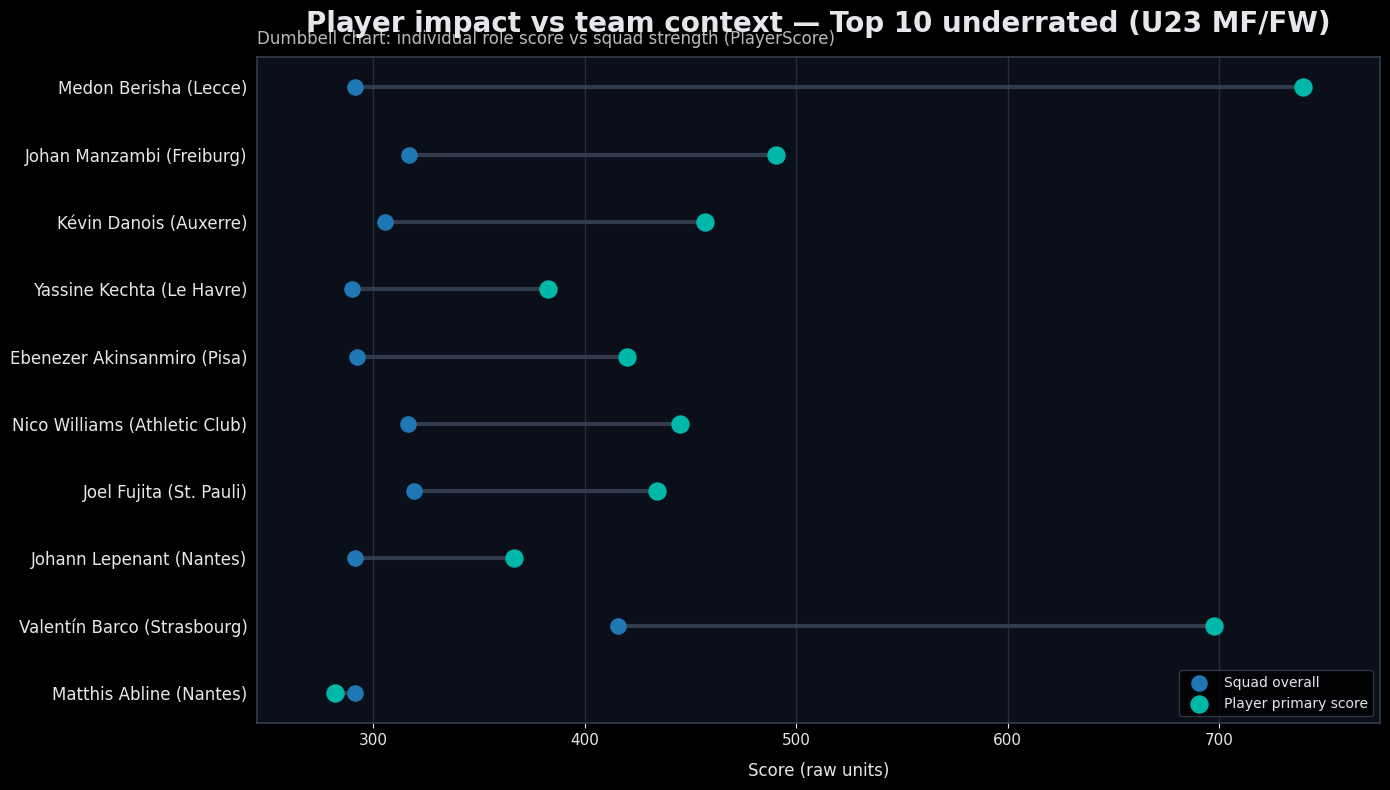

Saved: underrated_dumbbell_app_branding.png


In [78]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Colors (from your app) ----
PRIMARY_COLOR = "#1f77b4"
APP_BG = "#000000"
GRID_COLOR = "#374151"
TEXT_COLOR = "#e5e7eb"
VALUE_COLOR = "#00B8A9"

COLOR_ATTACKING = "#00B8A9"

# ---- Data ----
dfd = top10_out.copy()
dfd["label"] = dfd.apply(lambda r: f"{r['Player']} ({r['Squad']})", axis=1)
dfd = dfd.sort_values("Underrated", ascending=True).reset_index(drop=True)

y = np.arange(len(dfd))

# ---- Figure ----
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor(APP_BG)
ax.set_facecolor("#0b0f1a")  # leicht aufgehellt ggü. purem Schwarz

# ---- Dumbbell lines ----
ax.hlines(
    y,
    dfd["SquadOverall"],
    dfd["PrimaryScore"],
    color=GRID_COLOR,
    linewidth=3,
    alpha=0.9,
    zorder=1
)

# ---- Points ----
ax.scatter(
    dfd["SquadOverall"],
    y,
    s=120,
    color=PRIMARY_COLOR,
    label="Squad overall",
    zorder=3
)

ax.scatter(
    dfd["PrimaryScore"],
    y,
    s=150,
    color=COLOR_ATTACKING,
    label="Player primary score",
    zorder=4
)

# ---- Y labels ----
ax.set_yticks(y)
ax.set_yticklabels(dfd["label"], fontsize=12, color=TEXT_COLOR)

# ---- Axis / Grid ----
ax.tick_params(axis="x", colors=TEXT_COLOR, labelsize=11)
ax.grid(axis="x", color=GRID_COLOR, linewidth=1, alpha=0.6)
ax.grid(axis="y", visible=False)

for spine in ax.spines.values():
    spine.set_color(GRID_COLOR)
    spine.set_linewidth(1.1)

# ---- Titles ----
ax.set_title(
    "Player impact vs team context — Top 10 underrated (U23 MF/FW)",
    fontsize=20,
    fontweight="bold",
    color=TEXT_COLOR,
    pad=18
)

ax.text(
    0,
    1.02,
    "Dumbbell chart: individual role score vs squad strength (PlayerScore)",
    transform=ax.transAxes,
    fontsize=12,
    color=TEXT_COLOR,
    alpha=0.8
)

ax.set_xlabel("Score (raw units)", fontsize=12, color=TEXT_COLOR, labelpad=10)

# ---- Legend ----
leg = ax.legend(frameon=True, loc="lower right")
leg.get_frame().set_facecolor(APP_BG)
leg.get_frame().set_edgecolor(GRID_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

# ---- X limits padding ----
xmin = min(dfd["SquadOverall"].min(), dfd["PrimaryScore"].min())
xmax = max(dfd["SquadOverall"].max(), dfd["PrimaryScore"].max())
pad = (xmax - xmin) * 0.08 if xmax > xmin else 50
ax.set_xlim(xmin - pad, xmax + pad)

plt.tight_layout()

out_path = "underrated_dumbbell_app_branding.png"
plt.savefig(out_path, dpi=220, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

print("Saved:", out_path)

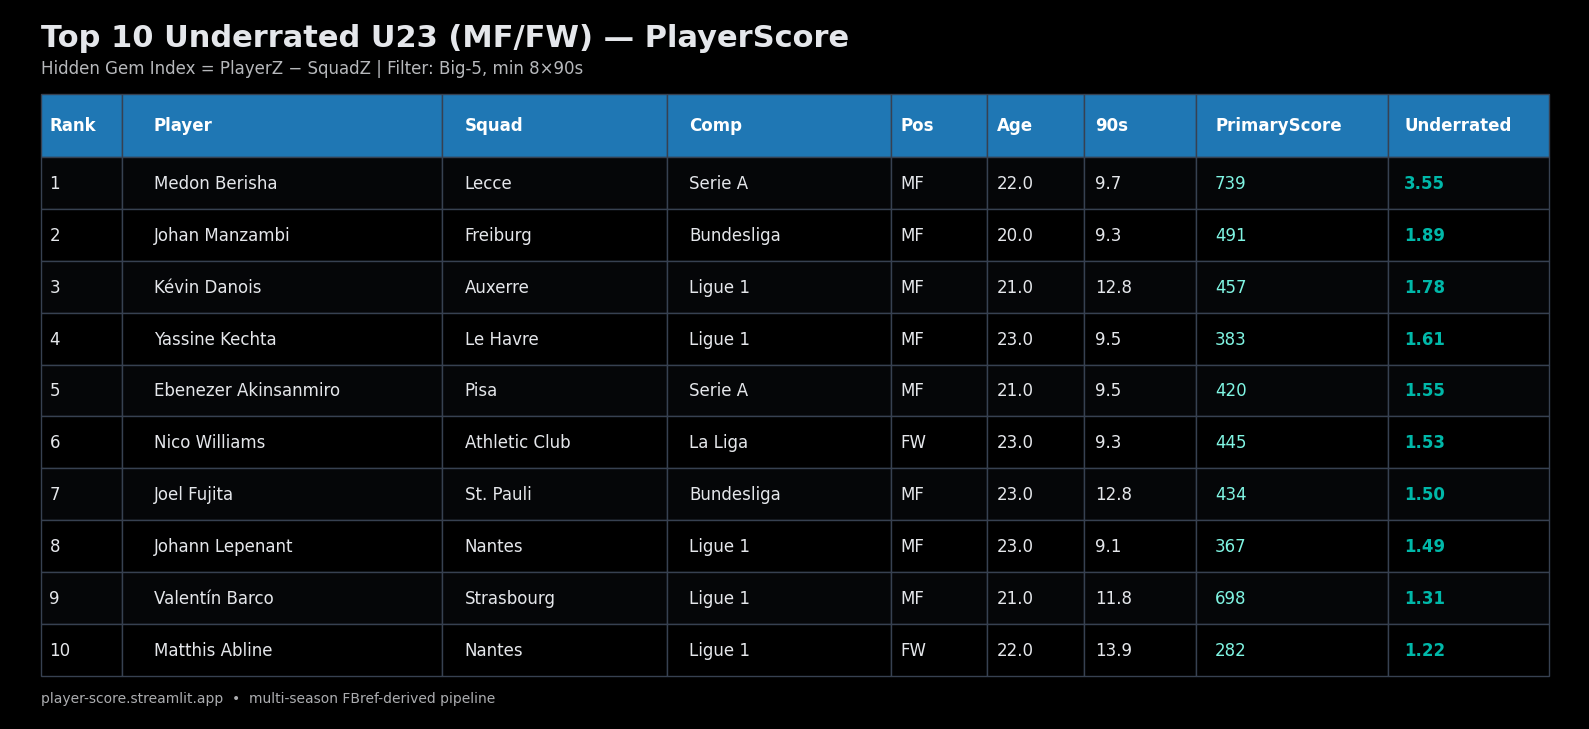

Saved: underrated_top10_table_app_branding.png


In [79]:
import matplotlib.pyplot as plt

# ---- Colors (from your app) ----
PRIMARY_COLOR = "#1f77b4"
APP_BG = "#000000"
GRID_COLOR = "#374151"
TEXT_COLOR = "#e5e7eb"
VALUE_COLOR = "#00B8A9"

COLOR_POSSESSION = "#80F5E3"
COLOR_ATTACKING  = "#00B8A9"
COLOR_DEFENDING  = "#006058"

# ---- Input ----
df = top10_out.copy()

# Sort: best on top
df = df.sort_values("Underrated", ascending=False).head(10).reset_index(drop=True)
df.insert(0, "Rank", df.index + 1)

# Columns to show
show_cols = ["Rank", "Player", "Squad", "Comp", "Pos", "Age", "90s", "PrimaryScore", "Underrated"]
df = df[show_cols].copy()

# Formatting
df["90s"] = df["90s"].map(lambda x: f"{x:.1f}")
df["PrimaryScore"] = df["PrimaryScore"].map(lambda x: f"{x:.0f}")
df["Underrated"] = df["Underrated"].map(lambda x: f"{x:.2f}")

df["Comp"] = df["Comp"].replace({
    "eng Premier League": "Premier League",
    "es La Liga": "La Liga",
    "it Serie A": "Serie A",
    "de Bundesliga": "Bundesliga",
    "fr Ligue 1": "Ligue 1",
})

title = "Top 10 Underrated U23 (MF/FW) — PlayerScore"
subtitle = "Hidden Gem Index = PlayerZ − SquadZ | Filter: Big-5, min 8×90s"

# ---- Table Theme ----
PANEL = "#07090d"          # near-black panel (still in your style)
HEADER_BG = PRIMARY_COLOR  # strong brand header
ROW_A = "#050608"
ROW_B = "#000000"

# ---- Figure ----
nrows, ncols = df.shape
fig_w = 16
fig_h = 1.35 + 0.55 * (nrows + 1)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
fig.patch.set_facecolor(APP_BG)
ax.set_facecolor(APP_BG)
ax.axis("off")

# Titles
ax.text(
    0.02, 0.98, title,
    transform=ax.transAxes, ha="left", va="top",
    fontsize=22, fontweight="bold", color=TEXT_COLOR
)
ax.text(
    0.02, 0.93, subtitle,
    transform=ax.transAxes, ha="left", va="top",
    fontsize=12, color=TEXT_COLOR, alpha=0.8
)

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="left",
    colLoc="left",
    bbox=[0.02, 0.06, 0.96, 0.82],
)

table.auto_set_font_size(False)
table.set_fontsize(12)

# Column widths (tweak)
col_widths = {
    "Rank": 0.05,
    "Player": 0.20,
    "Squad": 0.14,
    "Comp": 0.14,
    "Pos": 0.06,
    "Age": 0.06,
    "90s": 0.07,
    "PrimaryScore": 0.12,
    "Underrated": 0.10,
}

underrated_idx = list(df.columns).index("Underrated")
primary_idx = list(df.columns).index("PrimaryScore")

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor(GRID_COLOR)
    cell.set_linewidth(1.0)

    if row == 0:  # header
        cell.set_facecolor(HEADER_BG)
        cell.get_text().set_color("#ffffff")
        cell.get_text().set_fontweight("bold")
        cell.set_height(cell.get_height() * 1.20)
    else:
        cell.set_facecolor(ROW_A if row % 2 == 1 else ROW_B)
        cell.get_text().set_color(TEXT_COLOR)

        # Highlight important cols
        if col == underrated_idx:
            cell.get_text().set_color(COLOR_ATTACKING)   # teal accent
            cell.get_text().set_fontweight("bold")

        if col == primary_idx:
            cell.get_text().set_color(COLOR_POSSESSION)  # lighter teal for secondary highlight

    # width
    col_name = df.columns[col]
    if col_name in col_widths:
        cell.set_width(col_widths[col_name])

# Footer
ax.text(
    0.02, 0.02,
    "player-score.streamlit.app  •  multi-season FBref-derived pipeline",
    transform=ax.transAxes, ha="left", va="bottom",
    fontsize=10, color=TEXT_COLOR, alpha=0.75
)

plt.tight_layout()

out_path = "underrated_top10_table_app_branding.png"
plt.savefig(out_path, dpi=240, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

print("Saved:", out_path)

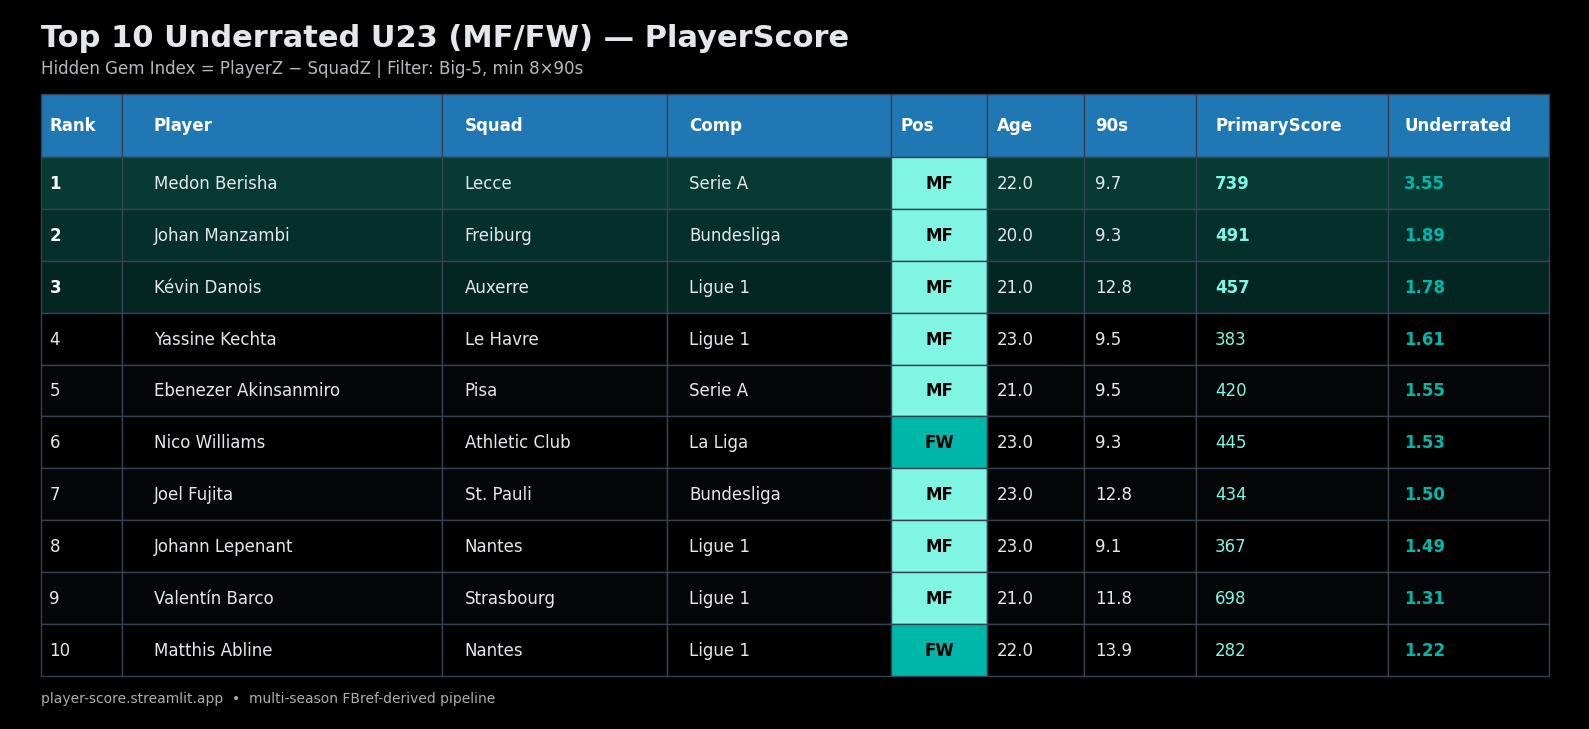

Saved: underrated_top10_table_app_branding_glow_poschips.png


In [80]:
import matplotlib.pyplot as plt

# ---- Colors (from your app) ----
PRIMARY_COLOR = "#1f77b4"
APP_BG = "#000000"
GRID_COLOR = "#374151"
TEXT_COLOR = "#e5e7eb"
VALUE_COLOR = "#00B8A9"

COLOR_POSSESSION = "#80F5E3"
COLOR_ATTACKING  = "#00B8A9"
COLOR_DEFENDING  = "#006058"

# ---- Input ----
df = top10_out.copy()

# Sort: best on top
df = df.sort_values("Underrated", ascending=False).head(10).reset_index(drop=True)
df.insert(0, "Rank", df.index + 1)

# Columns to show
show_cols = ["Rank", "Player", "Squad", "Comp", "Pos", "Age", "90s", "PrimaryScore", "Underrated"]
df = df[show_cols].copy()

# Formatting
df["90s"] = df["90s"].map(lambda x: f"{x:.1f}")
df["PrimaryScore"] = df["PrimaryScore"].map(lambda x: f"{x:.0f}")
df["Underrated"] = df["Underrated"].map(lambda x: f"{x:.2f}")

df["Comp"] = df["Comp"].replace({
    "eng Premier League": "Premier League",
    "es La Liga": "La Liga",
    "it Serie A": "Serie A",
    "de Bundesliga": "Bundesliga",
    "fr Ligue 1": "Ligue 1",
})

title = "Top 10 Underrated U23 (MF/FW) — PlayerScore"
subtitle = "Hidden Gem Index = PlayerZ − SquadZ | Filter: Big-5, min 8×90s"

# ---- Table Theme ----
HEADER_BG = PRIMARY_COLOR
ROW_A = "#050608"
ROW_B = "#000000"

# Top-3 glow (subtle background)
GLOW_1 = "#063a33"  # dark teal tint
GLOW_2 = "#052f2a"
GLOW_3 = "#042622"

# Pos chips
POS_CHIP = {
    "FW": COLOR_ATTACKING,
    "MF": COLOR_POSSESSION,
    "DF": COLOR_DEFENDING,
}

# ---- Figure ----
nrows, ncols = df.shape
fig_w = 16
fig_h = 1.35 + 0.55 * (nrows + 1)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
fig.patch.set_facecolor(APP_BG)
ax.set_facecolor(APP_BG)
ax.axis("off")

# Titles
ax.text(0.02, 0.98, title, transform=ax.transAxes,
        ha="left", va="top", fontsize=22, fontweight="bold", color=TEXT_COLOR)
ax.text(0.02, 0.93, subtitle, transform=ax.transAxes,
        ha="left", va="top", fontsize=12, color=TEXT_COLOR, alpha=0.8)

# Create table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="left",
    colLoc="left",
    bbox=[0.02, 0.06, 0.96, 0.82],
)

table.auto_set_font_size(False)
table.set_fontsize(12)

# Column widths (tweak)
col_widths = {
    "Rank": 0.05,
    "Player": 0.20,
    "Squad": 0.14,
    "Comp": 0.14,
    "Pos": 0.06,
    "Age": 0.06,
    "90s": 0.07,
    "PrimaryScore": 0.12,
    "Underrated": 0.10,
}

underrated_idx = list(df.columns).index("Underrated")
primary_idx = list(df.columns).index("PrimaryScore")
pos_idx = list(df.columns).index("Pos")
rank_idx = list(df.columns).index("Rank")

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor(GRID_COLOR)
    cell.set_linewidth(1.0)

    # Header
    if row == 0:
        cell.set_facecolor(HEADER_BG)
        cell.get_text().set_color("#ffffff")
        cell.get_text().set_fontweight("bold")
        cell.set_height(cell.get_height() * 1.20)
    else:
        # --- Base row background (zebra) ---
        base_bg = ROW_A if row % 2 == 1 else ROW_B

        # --- Top-3 glow override (row index: 1=Rank1, 2=Rank2, 3=Rank3) ---
        if row == 1:
            base_bg = GLOW_1
        elif row == 2:
            base_bg = GLOW_2
        elif row == 3:
            base_bg = GLOW_3

        cell.set_facecolor(base_bg)
        cell.get_text().set_color(TEXT_COLOR)

        # Highlight important cols
        if col == underrated_idx:
            cell.get_text().set_color(COLOR_ATTACKING)   # teal accent
            cell.get_text().set_fontweight("bold")

        if col == primary_idx:
            cell.get_text().set_color(COLOR_POSSESSION)  # lighter teal
            cell.get_text().set_fontweight("bold" if row in (1, 2, 3) else "normal")

        # --- Pos "chip" styling ---
        if col == pos_idx:
            pos = str(df.iloc[row-1, pos_idx])  # row-1 because header row = 0
            chip_color = POS_CHIP.get(pos, GRID_COLOR)
            cell.set_facecolor(chip_color)      # chip background
            cell.get_text().set_color("#000000")  # black text on bright chip
            cell.get_text().set_fontweight("bold")
            cell.get_text().set_ha("center")

        # Make Rank in top-3 pop a bit
        if col == rank_idx and row in (1, 2, 3):
            cell.get_text().set_fontweight("bold")
            cell.get_text().set_color("#ffffff")

    # width
    col_name = df.columns[col]
    if col_name in col_widths:
        cell.set_width(col_widths[col_name])

# Footer
ax.text(0.02, 0.02,
        "player-score.streamlit.app  •  multi-season FBref-derived pipeline",
        transform=ax.transAxes, ha="left", va="bottom",
        fontsize=10, color=TEXT_COLOR, alpha=0.75)

plt.tight_layout()

out_path = "underrated_top10_table_app_branding_glow_poschips.png"
plt.savefig(out_path, dpi=240, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

print("Saved:", out_path)

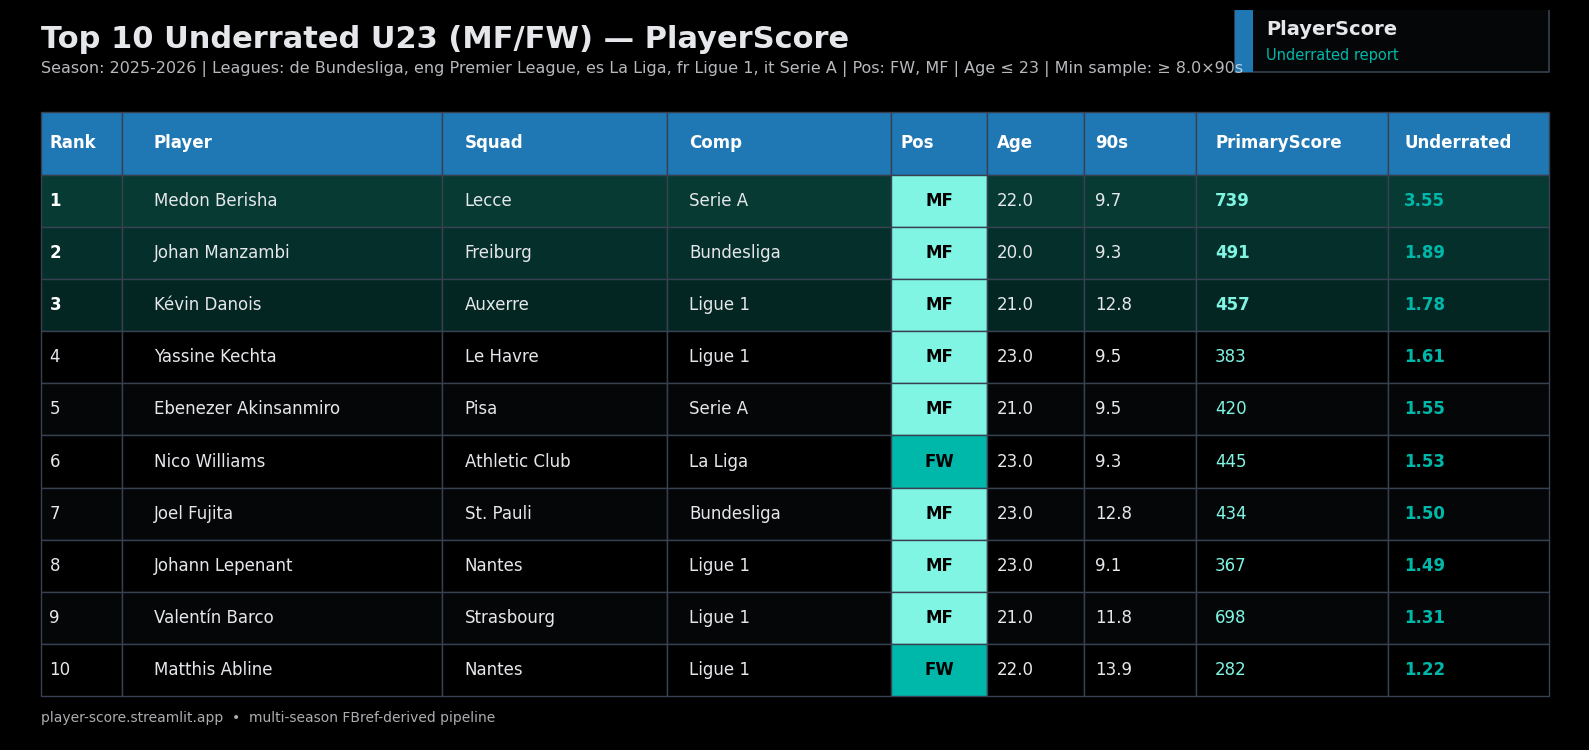

Saved: underrated_top10_table_app_branding_badge.png


In [81]:
import matplotlib.pyplot as plt

# ---- Colors (from your app) ----
PRIMARY_COLOR = "#1f77b4"
APP_BG = "#000000"
GRID_COLOR = "#374151"
TEXT_COLOR = "#e5e7eb"

COLOR_POSSESSION = "#80F5E3"
COLOR_ATTACKING  = "#00B8A9"
COLOR_DEFENDING  = "#006058"

# ---- Helper: build subtitle from data ----
def build_filter_line(df_top, df_view=None):
    # season
    season = None
    if "Season" in df_top.columns:
        s = df_top["Season"].dropna().astype(str).unique()
        season = s[0] if len(s) else None

    # 90s min (if view provided, infer min threshold from it)
    min_90s = None
    if df_view is not None and "90s" in df_view.columns:
        # we can't know the threshold exactly, so we report the minimum in view as "≥"
        min_90s = float(df_view["90s"].min())
    elif "90s" in df_top.columns:
        min_90s = float(df_top["90s"].min())

    # age max
    age_max = None
    if df_view is not None and "Age" in df_view.columns:
        age_max = int(df_view["Age"].max())
    elif "Age" in df_top.columns:
        age_max = int(df_top["Age"].max())

    # positions
    pos = None
    if "Pos" in df_top.columns:
        pos = ", ".join(sorted(df_top["Pos"].astype(str).unique()))

    # leagues
    comp = None
    if df_view is not None and "Comp" in df_view.columns:
        comps = df_view["Comp"].astype(str).unique()
        if len(comps) <= 5:
            comp = ", ".join(sorted(comps))
        else:
            comp = f"{len(comps)} leagues"
    elif "Comp" in df_top.columns:
        comps = df_top["Comp"].astype(str).unique()
        comp = ", ".join(sorted(comps[:5])) + ("…" if len(comps) > 5 else "")

    parts = []
    if season: parts.append(f"Season: {season}")
    if comp:   parts.append(f"Leagues: {comp}")
    if pos:    parts.append(f"Pos: {pos}")
    if age_max is not None: parts.append(f"Age ≤ {age_max}")
    if min_90s is not None: parts.append(f"Min sample: ≥ {min_90s:.1f}×90s")
    return " | ".join(parts)

# ---- Input ----
df = top10_out.copy()

# Sort: best on top
df = df.sort_values("Underrated", ascending=False).head(10).reset_index(drop=True)
df.insert(0, "Rank", df.index + 1)

# Columns to show
show_cols = ["Rank", "Player", "Squad", "Comp", "Pos", "Age", "90s", "PrimaryScore", "Underrated"]
df = df[show_cols].copy()

# Formatting
df["90s"] = df["90s"].map(lambda x: f"{x:.1f}")
df["PrimaryScore"] = df["PrimaryScore"].map(lambda x: f"{x:.0f}")
df["Underrated"] = df["Underrated"].map(lambda x: f"{x:.2f}")

df["Comp"] = df["Comp"].replace({
    "eng Premier League": "Premier League",
    "es La Liga": "La Liga",
    "it Serie A": "Serie A",
    "de Bundesliga": "Bundesliga",
    "fr Ligue 1": "Ligue 1",
})

title = "Top 10 Underrated U23 (MF/FW) — PlayerScore"
subtitle = build_filter_line(top10_out, df_view=globals().get("view", None))

# ---- Table Theme ----
HEADER_BG = PRIMARY_COLOR
ROW_A = "#050608"
ROW_B = "#000000"

# Top-3 glow
GLOW_1 = "#063a33"
GLOW_2 = "#052f2a"
GLOW_3 = "#042622"

# Pos chips
POS_CHIP = {"FW": COLOR_ATTACKING, "MF": COLOR_POSSESSION, "DF": COLOR_DEFENDING}

# ---- Figure ----
nrows, ncols = df.shape
fig_w = 16
fig_h = 1.55 + 0.55 * (nrows + 1)

fig, ax = plt.subplots(figsize=(fig_w, fig_h))
fig.patch.set_facecolor(APP_BG)
ax.set_facecolor(APP_BG)
ax.axis("off")

# Title & subtitle
ax.text(0.02, 0.98, title, transform=ax.transAxes,
        ha="left", va="top", fontsize=22, fontweight="bold", color=TEXT_COLOR)
ax.text(0.02, 0.93, subtitle, transform=ax.transAxes,
        ha="left", va="top", fontsize=11.5, color=TEXT_COLOR, alpha=0.80)

# ---- Badge (top-right) ----
# Badge box
badge_x, badge_y, badge_w, badge_h = 0.78, 0.915, 0.20, 0.09
badge = plt.Rectangle((badge_x, badge_y), badge_w, badge_h,
                      transform=ax.transAxes, facecolor="#050608",
                      edgecolor=GRID_COLOR, linewidth=1.2, joinstyle="round")
ax.add_patch(badge)

# Colored strip
strip = plt.Rectangle((badge_x, badge_y), 0.012, badge_h,
                      transform=ax.transAxes, facecolor=PRIMARY_COLOR, edgecolor="none")
ax.add_patch(strip)

# Badge text
ax.text(badge_x + 0.02, badge_y + 0.058, "PlayerScore",
        transform=ax.transAxes, ha="left", va="center",
        fontsize=14, fontweight="bold", color=TEXT_COLOR)

ax.text(badge_x + 0.02, badge_y + 0.022, "Underrated report",
        transform=ax.transAxes, ha="left", va="center",
        fontsize=10.5, color=COLOR_ATTACKING)

# ---- Create table ----
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="left",
    colLoc="left",
    bbox=[0.02, 0.06, 0.96, 0.80],
)

table.auto_set_font_size(False)
table.set_fontsize(12)

col_widths = {
    "Rank": 0.05,
    "Player": 0.20,
    "Squad": 0.14,
    "Comp": 0.14,
    "Pos": 0.06,
    "Age": 0.06,
    "90s": 0.07,
    "PrimaryScore": 0.12,
    "Underrated": 0.10,
}

underrated_idx = list(df.columns).index("Underrated")
primary_idx = list(df.columns).index("PrimaryScore")
pos_idx = list(df.columns).index("Pos")
rank_idx = list(df.columns).index("Rank")

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor(GRID_COLOR)
    cell.set_linewidth(1.0)

    if row == 0:
        cell.set_facecolor(HEADER_BG)
        cell.get_text().set_color("#ffffff")
        cell.get_text().set_fontweight("bold")
        cell.set_height(cell.get_height() * 1.20)
    else:
        base_bg = ROW_A if row % 2 == 1 else ROW_B

        if row == 1: base_bg = GLOW_1
        if row == 2: base_bg = GLOW_2
        if row == 3: base_bg = GLOW_3

        cell.set_facecolor(base_bg)
        cell.get_text().set_color(TEXT_COLOR)

        if col == underrated_idx:
            cell.get_text().set_color(COLOR_ATTACKING)
            cell.get_text().set_fontweight("bold")

        if col == primary_idx:
            cell.get_text().set_color(COLOR_POSSESSION)
            cell.get_text().set_fontweight("bold" if row in (1,2,3) else "normal")

        if col == pos_idx:
            pos = str(df.iloc[row-1, pos_idx])
            chip_color = POS_CHIP.get(pos, GRID_COLOR)
            cell.set_facecolor(chip_color)
            cell.get_text().set_color("#000000")
            cell.get_text().set_fontweight("bold")
            cell.get_text().set_ha("center")

        if col == rank_idx and row in (1,2,3):
            cell.get_text().set_fontweight("bold")
            cell.get_text().set_color("#ffffff")

    col_name = df.columns[col]
    if col_name in col_widths:
        cell.set_width(col_widths[col_name])

# Footer
ax.text(0.02, 0.02,
        "player-score.streamlit.app  •  multi-season FBref-derived pipeline",
        transform=ax.transAxes, ha="left", va="bottom",
        fontsize=10, color=TEXT_COLOR, alpha=0.75)

plt.tight_layout()

out_path = "underrated_top10_table_app_branding_badge.png"
plt.savefig(out_path, dpi=260, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

print("Saved:", out_path)

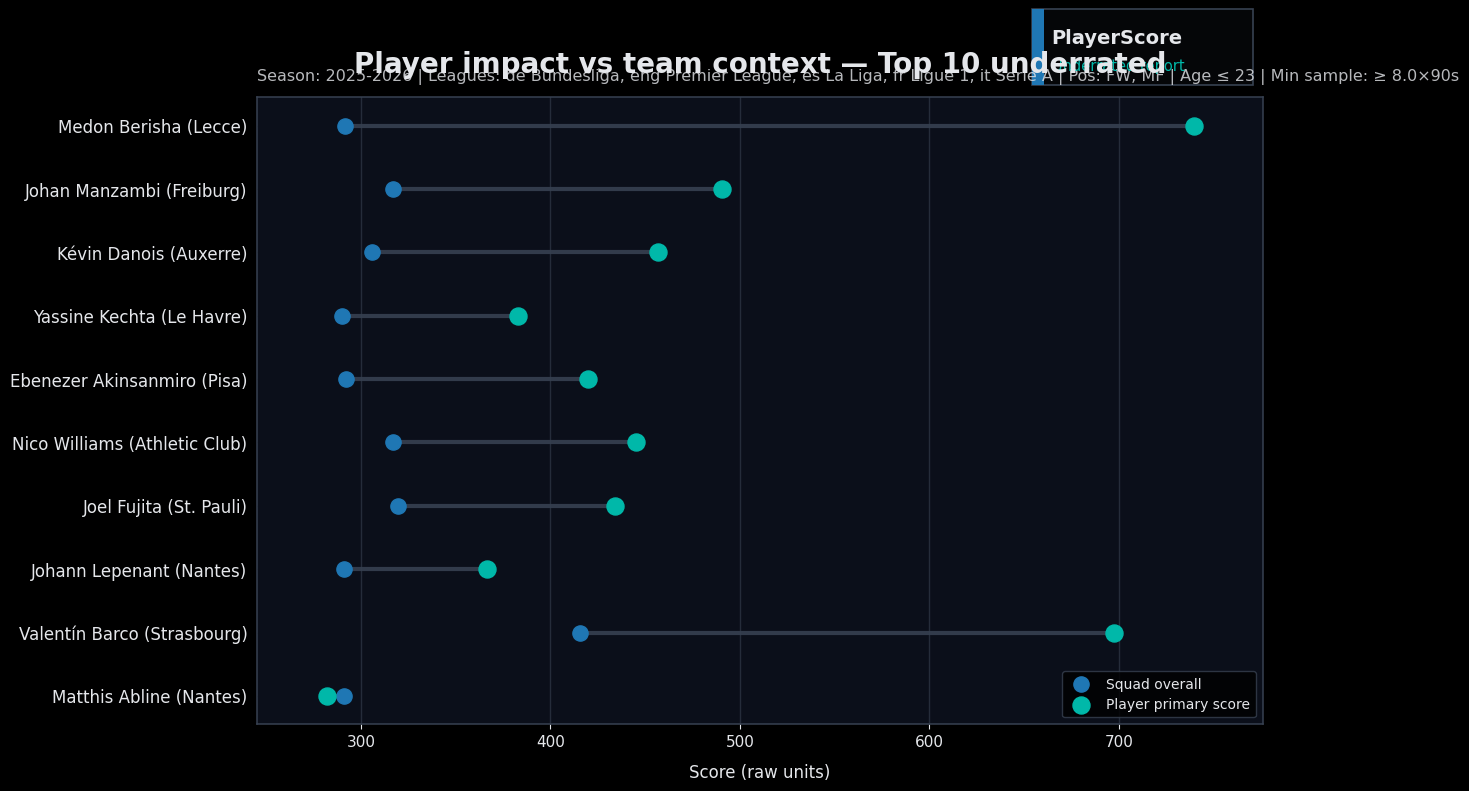

Saved: underrated_dumbbell_app_branding_badge.png


In [82]:
import matplotlib.pyplot as plt
import numpy as np

# ---- Colors (from your app) ----
PRIMARY_COLOR = "#1f77b4"
APP_BG = "#000000"
GRID_COLOR = "#374151"
TEXT_COLOR = "#e5e7eb"

COLOR_ATTACKING  = "#00B8A9"
COLOR_POSSESSION = "#80F5E3"
COLOR_DEFENDING  = "#006058"

# ---- Helper: build subtitle from data ----
def build_filter_line(df_top, df_view=None):
    season = None
    if "Season" in df_top.columns:
        s = df_top["Season"].dropna().astype(str).unique()
        season = s[0] if len(s) else None

    min_90s = None
    if df_view is not None and "90s" in df_view.columns:
        min_90s = float(df_view["90s"].min())
    elif "90s" in df_top.columns:
        min_90s = float(df_top["90s"].min())

    age_max = None
    if df_view is not None and "Age" in df_view.columns:
        age_max = int(df_view["Age"].max())
    elif "Age" in df_top.columns:
        age_max = int(df_top["Age"].max())

    pos = None
    if "Pos" in df_top.columns:
        pos = ", ".join(sorted(df_top["Pos"].astype(str).unique()))

    comp = None
    if df_view is not None and "Comp" in df_view.columns:
        comps = df_view["Comp"].astype(str).unique()
        if len(comps) <= 5:
            comp = ", ".join(sorted(comps))
        else:
            comp = f"{len(comps)} leagues"
    elif "Comp" in df_top.columns:
        comps = df_top["Comp"].astype(str).unique()
        comp = ", ".join(sorted(comps[:5])) + ("…" if len(comps) > 5 else "")

    parts = []
    if season: parts.append(f"Season: {season}")
    if comp:   parts.append(f"Leagues: {comp}")
    if pos:    parts.append(f"Pos: {pos}")
    if age_max is not None: parts.append(f"Age ≤ {age_max}")
    if min_90s is not None: parts.append(f"Min sample: ≥ {min_90s:.1f}×90s")
    return " | ".join(parts)

# ---- Data ----
dfd = top10_out.copy()
dfd["label"] = dfd.apply(lambda r: f"{r['Player']} ({r['Squad']})", axis=1)
dfd = dfd.sort_values("Underrated", ascending=True).reset_index(drop=True)

y = np.arange(len(dfd))

# ---- Figure ----
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor(APP_BG)
ax.set_facecolor("#0b0f1a")  # slightly lighter panel

# ---- Dumbbell lines ----
ax.hlines(
    y,
    dfd["SquadOverall"],
    dfd["PrimaryScore"],
    color=GRID_COLOR,
    linewidth=3,
    alpha=0.9,
    zorder=1
)

# ---- Points ----
ax.scatter(
    dfd["SquadOverall"], y,
    s=120, color=PRIMARY_COLOR,
    label="Squad overall",
    zorder=3
)
ax.scatter(
    dfd["PrimaryScore"], y,
    s=150, color=COLOR_ATTACKING,
    label="Player primary score",
    zorder=4
)

# ---- Y labels ----
ax.set_yticks(y)
ax.set_yticklabels(dfd["label"], fontsize=12, color=TEXT_COLOR)

# ---- Axis + grid ----
ax.tick_params(axis="x", colors=TEXT_COLOR, labelsize=11)
ax.grid(axis="x", color=GRID_COLOR, linewidth=1, alpha=0.6)
ax.grid(axis="y", visible=False)

for spine in ax.spines.values():
    spine.set_color(GRID_COLOR)
    spine.set_linewidth(1.1)

# ---- Titles + subtitle ----
title = "Player impact vs team context — Top 10 underrated"
subtitle = build_filter_line(top10_out, df_view=globals().get("view", None))

ax.set_title(title, fontsize=20, fontweight="bold", color=TEXT_COLOR, pad=18)
ax.text(
    0.0, 1.02, subtitle,
    transform=ax.transAxes, fontsize=11.5, color=TEXT_COLOR, alpha=0.80, va="bottom"
)

ax.set_xlabel("Score (raw units)", fontsize=12, color=TEXT_COLOR, labelpad=10)

# ---- Badge (top-right) ----
badge_x, badge_y, badge_w, badge_h = 0.77, 1.02, 0.22, 0.12  # y>1 goes above plot area
badge = plt.Rectangle(
    (badge_x, badge_y), badge_w, badge_h,
    transform=ax.transAxes, facecolor="#050608",
    edgecolor=GRID_COLOR, linewidth=1.2, clip_on=False
)
ax.add_patch(badge)

strip = plt.Rectangle(
    (badge_x, badge_y), 0.012, badge_h,
    transform=ax.transAxes, facecolor=PRIMARY_COLOR,
    edgecolor="none", clip_on=False
)
ax.add_patch(strip)

ax.text(
    badge_x + 0.02, badge_y + 0.075, "PlayerScore",
    transform=ax.transAxes, ha="left", va="center",
    fontsize=14, fontweight="bold", color=TEXT_COLOR, clip_on=False
)
ax.text(
    badge_x + 0.02, badge_y + 0.030, "Underrated report",
    transform=ax.transAxes, ha="left", va="center",
    fontsize=10.5, color=COLOR_ATTACKING, clip_on=False
)

# ---- Legend ----
leg = ax.legend(frameon=True, loc="lower right")
leg.get_frame().set_facecolor(APP_BG)
leg.get_frame().set_edgecolor(GRID_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

# ---- X limits padding ----
xmin = min(dfd["SquadOverall"].min(), dfd["PrimaryScore"].min())
xmax = max(dfd["SquadOverall"].max(), dfd["PrimaryScore"].max())
pad = (xmax - xmin) * 0.08 if xmax > xmin else 50
ax.set_xlim(xmin - pad, xmax + pad)

plt.tight_layout()

out_path = "underrated_dumbbell_app_branding_badge.png"
plt.savefig(out_path, dpi=260, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

print("Saved:", out_path)

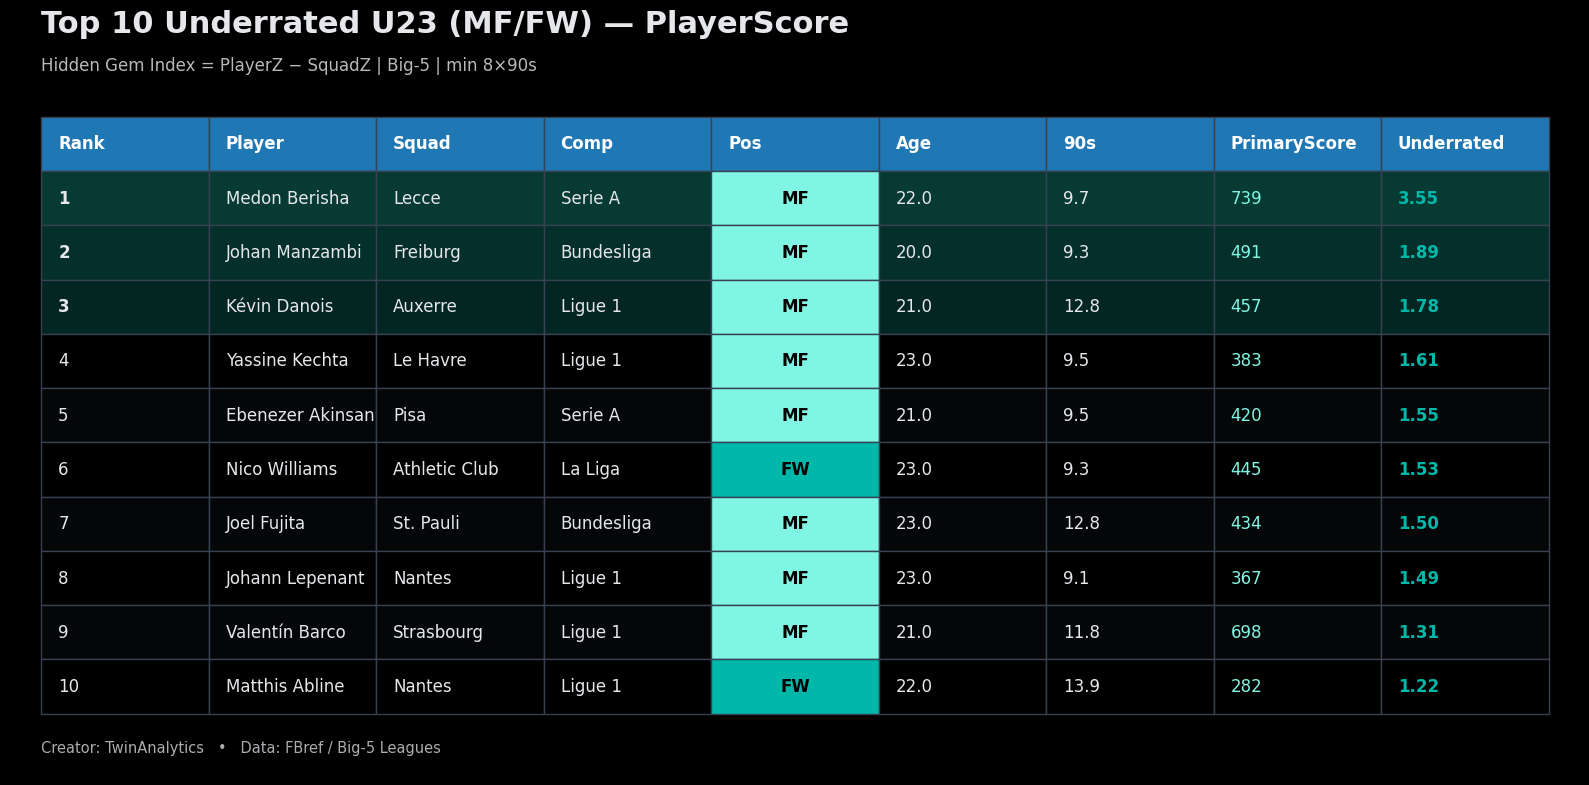

In [83]:
import matplotlib.pyplot as plt

# ---- Colors (from your app) ----
PRIMARY_COLOR = "#1f77b4"
APP_BG = "#000000"
GRID_COLOR = "#374151"
TEXT_COLOR = "#e5e7eb"

COLOR_POSSESSION = "#80F5E3"
COLOR_ATTACKING  = "#00B8A9"
COLOR_DEFENDING  = "#006058"

# ---- Input ----
df = top10_out.copy()
df = df.sort_values("Underrated", ascending=False).head(10).reset_index(drop=True)
df.insert(0, "Rank", df.index + 1)

show_cols = ["Rank","Player","Squad","Comp","Pos","Age","90s","PrimaryScore","Underrated"]
df = df[show_cols]

df["90s"] = df["90s"].map(lambda x: f"{x:.1f}")
df["PrimaryScore"] = df["PrimaryScore"].map(lambda x: f"{x:.0f}")
df["Underrated"] = df["Underrated"].map(lambda x: f"{x:.2f}")

df["Comp"] = df["Comp"].replace({
    "eng Premier League":"Premier League",
    "es La Liga":"La Liga",
    "it Serie A":"Serie A",
    "de Bundesliga":"Bundesliga",
    "fr Ligue 1":"Ligue 1",
})

title = "Top 10 Underrated U23 (MF/FW) — PlayerScore"
subtitle = "Hidden Gem Index = PlayerZ − SquadZ | Big-5 | min 8×90s"

# ---- Table Theme ----
HEADER_BG = PRIMARY_COLOR
ROW_A, ROW_B = "#050608", "#000000"
GLOW_1, GLOW_2, GLOW_3 = "#063a33", "#052f2a", "#042622"

POS_CHIP = {"FW": COLOR_ATTACKING, "MF": COLOR_POSSESSION, "DF": COLOR_DEFENDING}

# ---- Figure ----
fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor(APP_BG)
ax.set_facecolor(APP_BG)
ax.axis("off")

ax.text(0.02, 0.97, title, transform=ax.transAxes,
        fontsize=22, fontweight="bold", color=TEXT_COLOR)
ax.text(0.02, 0.92, subtitle, transform=ax.transAxes,
        fontsize=12, color=TEXT_COLOR, alpha=0.8)

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="left",
    colLoc="left",
    bbox=[0.02, 0.08, 0.96, 0.78]
)

table.auto_set_font_size(False)
table.set_fontsize(12)

underrated_idx = list(df.columns).index("Underrated")
primary_idx = list(df.columns).index("PrimaryScore")
pos_idx = list(df.columns).index("Pos")
rank_idx = list(df.columns).index("Rank")

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor(GRID_COLOR)
    cell.set_linewidth(1)

    if row == 0:
        cell.set_facecolor(HEADER_BG)
        cell.get_text().set_color("#ffffff")
        cell.get_text().set_fontweight("bold")
    else:
        bg = ROW_A if row % 2 else ROW_B
        if row == 1: bg = GLOW_1
        if row == 2: bg = GLOW_2
        if row == 3: bg = GLOW_3

        cell.set_facecolor(bg)
        cell.get_text().set_color(TEXT_COLOR)

        if col == underrated_idx:
            cell.get_text().set_color(COLOR_ATTACKING)
            cell.get_text().set_fontweight("bold")

        if col == primary_idx:
            cell.get_text().set_color(COLOR_POSSESSION)

        if col == pos_idx:
            pos = df.iloc[row-1, pos_idx]
            cell.set_facecolor(POS_CHIP.get(pos, GRID_COLOR))
            cell.get_text().set_color("#000000")
            cell.get_text().set_fontweight("bold")
            cell.get_text().set_ha("center")

        if col == rank_idx and row in (1,2,3):
            cell.get_text().set_fontweight("bold")

# ---- Footer ----
ax.text(
    0.02, 0.03,
    "Creator: TwinAnalytics   •   Data: FBref / Big-5 Leagues",
    transform=ax.transAxes,
    fontsize=10.5,
    color=TEXT_COLOR,
    alpha=0.75
)

plt.tight_layout()
plt.savefig("underrated_table_clean.png", dpi=260, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

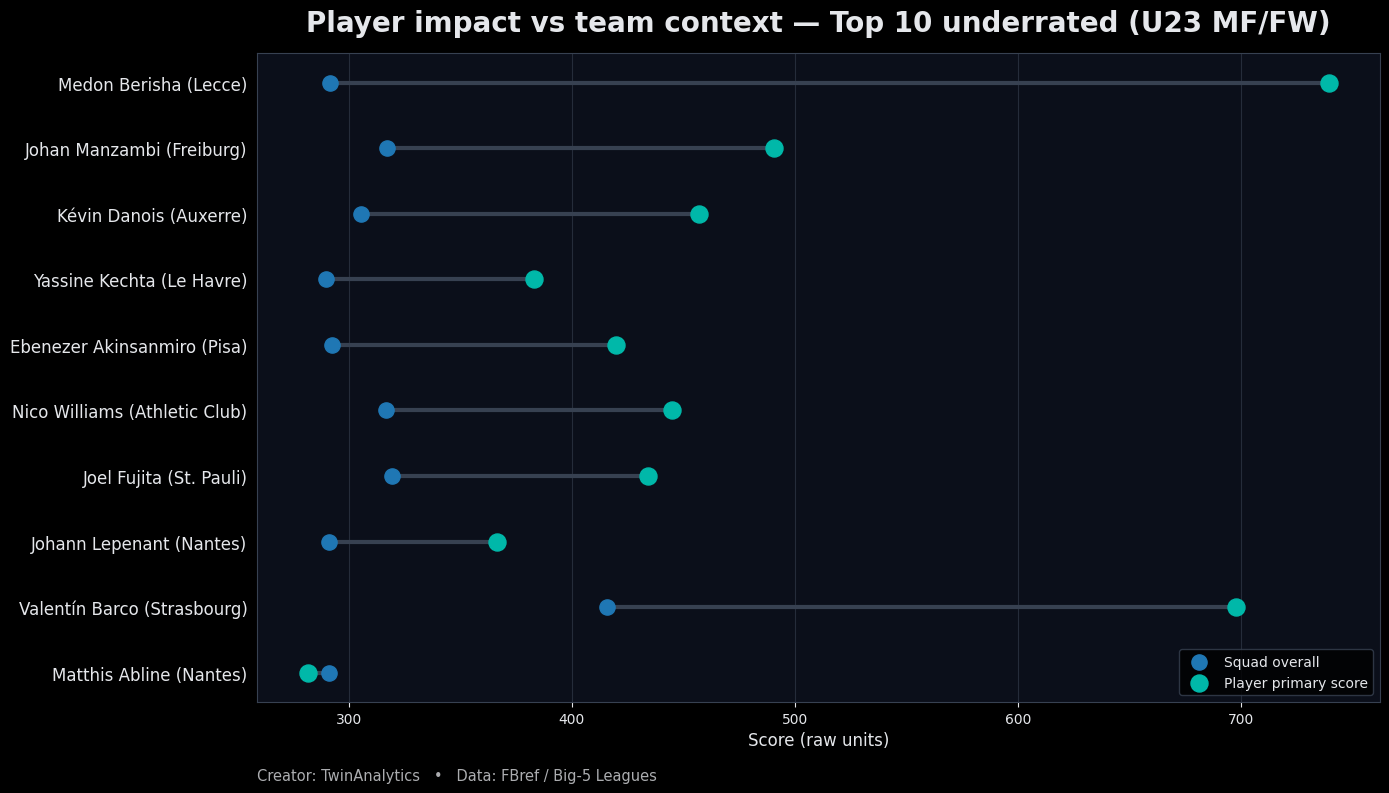

In [84]:
import matplotlib.pyplot as plt
import numpy as np

PRIMARY_COLOR = "#1f77b4"
APP_BG = "#000000"
GRID_COLOR = "#374151"
TEXT_COLOR = "#e5e7eb"
COLOR_ATTACKING = "#00B8A9"

dfd = top10_out.copy()
dfd["label"] = dfd.apply(lambda r: f"{r['Player']} ({r['Squad']})", axis=1)
dfd = dfd.sort_values("Underrated", ascending=True).reset_index(drop=True)

y = np.arange(len(dfd))

fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor(APP_BG)
ax.set_facecolor("#0b0f1a")

ax.hlines(y, dfd["SquadOverall"], dfd["PrimaryScore"],
          color=GRID_COLOR, linewidth=3)

ax.scatter(dfd["SquadOverall"], y, s=120,
           color=PRIMARY_COLOR, label="Squad overall", zorder=3)

ax.scatter(dfd["PrimaryScore"], y, s=150,
           color=COLOR_ATTACKING, label="Player primary score", zorder=4)

ax.set_yticks(y)
ax.set_yticklabels(dfd["label"], fontsize=12, color=TEXT_COLOR)

ax.tick_params(axis="x", colors=TEXT_COLOR)
ax.grid(axis="x", color=GRID_COLOR, alpha=0.6)
ax.grid(axis="y", visible=False)

for s in ax.spines.values():
    s.set_color(GRID_COLOR)

ax.set_title(
    "Player impact vs team context — Top 10 underrated (U23 MF/FW)",
    fontsize=20, fontweight="bold", color=TEXT_COLOR, pad=16
)

ax.set_xlabel("Score (raw units)", fontsize=12, color=TEXT_COLOR)

leg = ax.legend(frameon=True, loc="lower right")
leg.get_frame().set_facecolor(APP_BG)
leg.get_frame().set_edgecolor(GRID_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

# ---- Footer ----
ax.text(
    0.0, -0.12,
    "Creator: TwinAnalytics   •   Data: FBref / Big-5 Leagues",
    transform=ax.transAxes,
    fontsize=10.5,
    color=TEXT_COLOR,
    alpha=0.75
)

plt.tight_layout()
plt.savefig("underrated_dumbbell_clean.png", dpi=260, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.show()

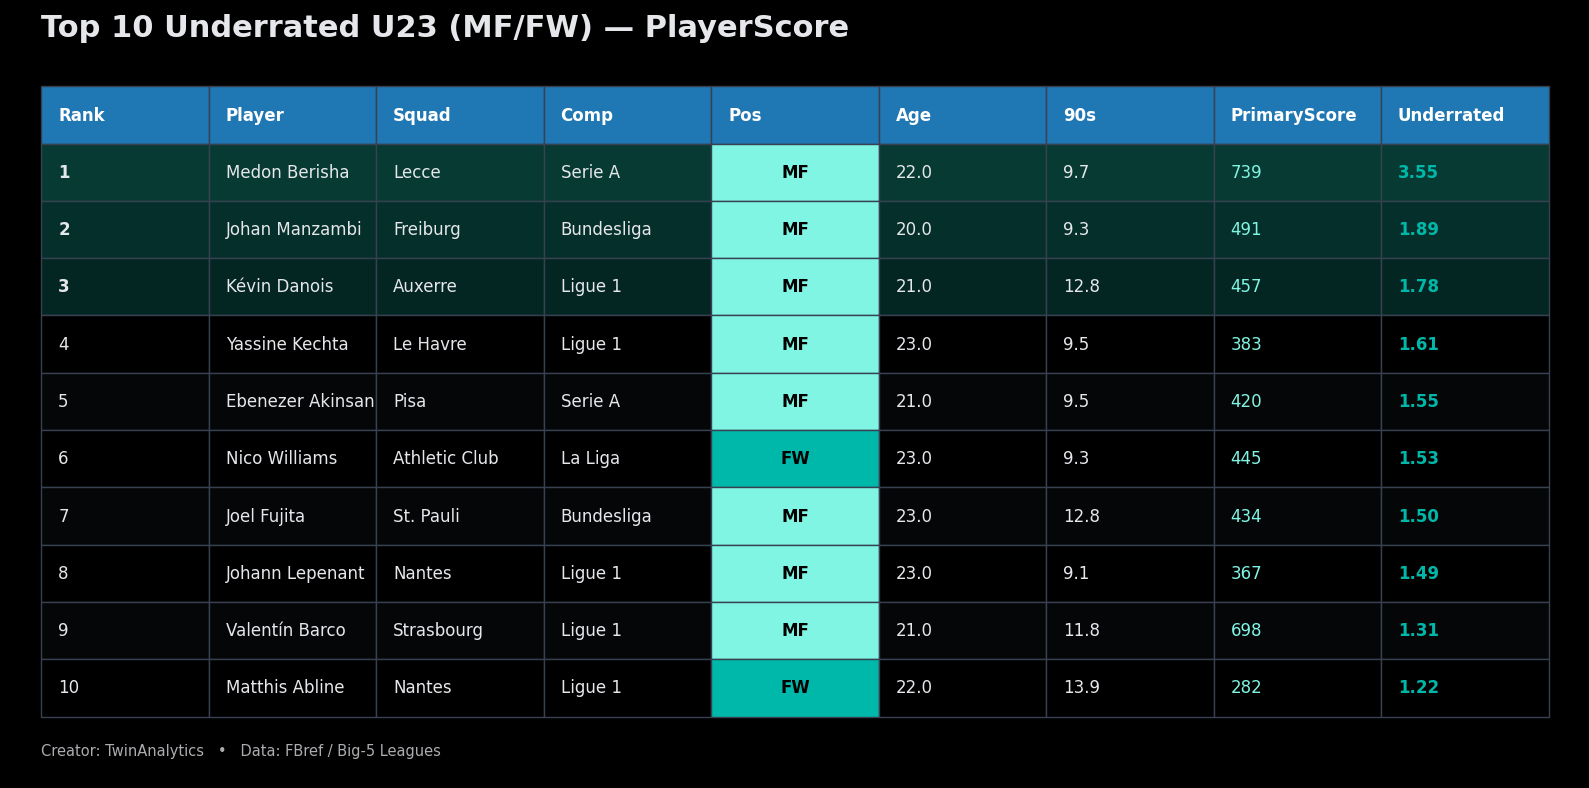

In [85]:
import matplotlib.pyplot as plt

# ---- Colors (from your app) ----
PRIMARY_COLOR = "#1f77b4"
APP_BG = "#000000"
GRID_COLOR = "#374151"
TEXT_COLOR = "#e5e7eb"

COLOR_POSSESSION = "#80F5E3"
COLOR_ATTACKING  = "#00B8A9"
COLOR_DEFENDING  = "#006058"

# ---- Input ----
df = top10_out.copy()
df = df.sort_values("Underrated", ascending=False).head(10).reset_index(drop=True)
df.insert(0, "Rank", df.index + 1)

show_cols = ["Rank","Player","Squad","Comp","Pos","Age","90s","PrimaryScore","Underrated"]
df = df[show_cols]

df["90s"] = df["90s"].map(lambda x: f"{x:.1f}")
df["PrimaryScore"] = df["PrimaryScore"].map(lambda x: f"{x:.0f}")
df["Underrated"] = df["Underrated"].map(lambda x: f"{x:.2f}")

df["Comp"] = df["Comp"].replace({
    "eng Premier League":"Premier League",
    "es La Liga":"La Liga",
    "it Serie A":"Serie A",
    "de Bundesliga":"Bundesliga",
    "fr Ligue 1":"Ligue 1",
})

title = "Top 10 Underrated U23 (MF/FW) — PlayerScore"

# ---- Table Theme ----
HEADER_BG = PRIMARY_COLOR
ROW_A, ROW_B = "#050608", "#000000"
GLOW_1, GLOW_2, GLOW_3 = "#063a33", "#052f2a", "#042622"

POS_CHIP = {"FW": COLOR_ATTACKING, "MF": COLOR_POSSESSION, "DF": COLOR_DEFENDING}

# ---- Figure ----
fig, ax = plt.subplots(figsize=(16, 8))
fig.patch.set_facecolor(APP_BG)
ax.set_facecolor(APP_BG)
ax.axis("off")

# ---- Title (only one) ----
ax.text(
    0.02, 0.965, title,
    transform=ax.transAxes,
    fontsize=22,
    fontweight="bold",
    color=TEXT_COLOR
)

# ---- Table ----
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="left",
    colLoc="left",
    bbox=[0.02, 0.08, 0.96, 0.82]
)

table.auto_set_font_size(False)
table.set_fontsize(12)

underrated_idx = list(df.columns).index("Underrated")
primary_idx = list(df.columns).index("PrimaryScore")
pos_idx = list(df.columns).index("Pos")
rank_idx = list(df.columns).index("Rank")

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor(GRID_COLOR)
    cell.set_linewidth(1)

    if row == 0:
        cell.set_facecolor(HEADER_BG)
        cell.get_text().set_color("#ffffff")
        cell.get_text().set_fontweight("bold")
    else:
        bg = ROW_A if row % 2 else ROW_B
        if row == 1: bg = GLOW_1
        if row == 2: bg = GLOW_2
        if row == 3: bg = GLOW_3

        cell.set_facecolor(bg)
        cell.get_text().set_color(TEXT_COLOR)

        if col == underrated_idx:
            cell.get_text().set_color(COLOR_ATTACKING)
            cell.get_text().set_fontweight("bold")

        if col == primary_idx:
            cell.get_text().set_color(COLOR_POSSESSION)

        if col == pos_idx:
            pos = df.iloc[row-1, pos_idx]
            cell.set_facecolor(POS_CHIP.get(pos, GRID_COLOR))
            cell.get_text().set_color("#000000")
            cell.get_text().set_fontweight("bold")
            cell.get_text().set_ha("center")

        if col == rank_idx and row in (1,2,3):
            cell.get_text().set_fontweight("bold")

# ---- Footer ----
ax.text(
    0.02, 0.03,
    "Creator: TwinAnalytics   •   Data: FBref / Big-5 Leagues",
    transform=ax.transAxes,
    fontsize=10.5,
    color=TEXT_COLOR,
    alpha=0.75
)

plt.tight_layout()
plt.savefig(
    "underrated_table_clean_onetitle.png",
    dpi=260,
    bbox_inches="tight",
    facecolor=fig.get_facecolor()
)
plt.show()